In [1]:
# %reset -f

import sys
import os
import joblib
import matplotlib
import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# install custom package with: pip install git+https://github.com/owenodriscoll/AutoML.git
from AutoML import AutomatedRegression

/export/home/owen/anaconda3/envs/env_paper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.insert(0, os.path.abspath('..'))  # hacky way to import within package
from src import equations_misc as eqm

In [4]:
#%% load data

data_dir = '/export/home/owen/Documents/scripts/SAR_paper/data/'
df = pd.read_csv(f'{data_dir}df_buoys.csv')

In [5]:
#%% filtering of estimates 

# -- conditions for filtering
min_heatflux = 0 # (into atmos)
max_obukhov = 0

# -- filtering
df_filt = df.loc[(df['L_era5'] < max_obukhov) & (df['hsb_era5'] > min_heatflux) & (df['L'] < max_obukhov) & (df['hsb'] > min_heatflux)]

# -- filter in size 
df_val = eqm.sample_data(df_filt, 'buoy', 1000)

# -- select observation data (buoy measurements)
df_obs = df_val[['depth_airt', 'depth_seat', 'depth_relh', 'depth_wind',
                 'tair', 'tsea', 'relh', 'wspd', 'wdir']]

# -- set all depths and heights to absolute value, as inconsistent usage
df_obs[['depth_airt', 'depth_seat', 'depth_relh', 'depth_wind']] = abs(df_obs[['depth_airt', 'depth_seat', 'depth_relh', 'depth_wind']])

/tmp/ipykernel_5027/701050564.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs[['depth_airt', 'depth_seat', 'depth_relh', 'depth_wind']] = abs(df_obs[['depth_airt', 'depth_seat', 'depth_relh', 'depth_wind']])


In [6]:
#%% split data and prepare functions

# -- observation
X = df_obs

# -- validation
y = np.log10(abs(df_val['L_era5'])) 

In [10]:
#%% Apply the (Machine Learning) regression

result = AutomatedRegression(
    y = y, 
    X = X, 
    test_frac = 0.2, 
    timeout = 300,  # currently times out after 300 seconds, for study set to 2400
    n_trial = 20,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = median_absolute_error,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = False,
    optimisation_direction = 'minimize', 
    write_folder = f'{data_dir}/examp_buoy_era5_regression_buoy_to_era5',
    models_to_optimize = ['lightgbm', 'catboost', 'xgboost','bayesianridge', 'lassolars'],
    random_state = 42)

In [11]:
result.apply()

[I 2023-03-30 09:25:27,249] A new study created in RDB with name: regression_lightgbm
[I 2023-03-30 09:25:28,476] Trial 0 finished with value: 0.18349888955302335 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 5, 'n_estimators': 88, 'max_bin': 127, 'min_gain_to_split': 14.548647782429915, 'lambda_l1': 0.31044435499483225, 'lambda_l2': 8.148018307012941e-07, 'num_leaves': 48, 'feature_fraction': 0.2650640588680905, 'bagging_fraction': 0.373818018663584, 'bagging_freq': 4, 'min_child_samples': 44, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 600}. Best is trial 0 with value: 0.18349888955302335.
[I 2023-03-30 09:25:36,298] Trial 1 finished with value: 0.16351659558167977 and parameters: {'scaler': 'robust', 'objective': 'regression', 'max_depth': 6, 'n_estimators': 332, 'max_bin': 255, 'min_gain_to_split': 14.233283058799998, 'lambda_l1': 4.905556676028774, 'lambda_l2': 0.18861495878553936, 'num_leaves': 79, 'feature_

[I 2023-03-30 09:27:56,178] A new study created in RDB with name: regression_catboost
[I 2023-03-30 09:27:58,258] Trial 0 finished with value: 0.15239361267972829 and parameters: {'scaler': 'robust', 'depth': 5, 'iterations': 65, 'learning_rate': 0.21342185100977323, 'l2_leaf_reg': 0.10529569628032458, 'rsm': 0.931449752347529, 'logging_level': 'Silent', 'random_seed': 42, 'transformers': None}. Best is trial 0 with value: 0.15239361267972829.
[I 2023-03-30 09:28:16,227] Trial 1 finished with value: 0.16280180539243058 and parameters: {'scaler': 'robust', 'depth': 6, 'iterations': 237, 'learning_rate': 0.02725296361559705, 'l2_leaf_reg': 4.859254947164246, 'rsm': 0.3953096619468215, 'logging_level': 'Silent', 'random_seed': 42, 'transformers': 'quantile_trans', 'n_quantiles': 400}. Best is trial 0 with value: 0.15239361267972829.
[I 2023-03-30 09:28:18,835] Trial 2 pruned. 
[I 2023-03-30 09:28:22,037] Trial 3 pruned. 
[I 2023-03-30 09:28:40,914] Trial 4 finished with value: 0.172147997

[I 2023-03-30 09:37:36,019] Trial 13 pruned. 
[I 2023-03-30 09:37:37,978] Trial 14 finished with value: 0.17601327390804702 and parameters: {'scaler': 'standard', 'n_iter': 97, 'tol': 45.24395161874495, 'alpha_1': 2.5619473699696556e-07, 'alpha_2': 5.805904194110475e-07, 'lambda_1': 0.0009631140698677091, 'lambda_2': 0.00015461602185941993, 'transformers': None}. Best is trial 14 with value: 0.17601327390804702.
[I 2023-03-30 09:37:39,470] Trial 15 pruned. 
[I 2023-03-30 09:37:41,586] Trial 16 finished with value: 0.176013290388946 and parameters: {'scaler': 'standard', 'n_iter': 14, 'tol': 70.52366034823123, 'alpha_1': 2.0095308872662634e-06, 'alpha_2': 8.598953291240033e-08, 'lambda_1': 0.012376548900696522, 'lambda_2': 0.12206512127392277, 'transformers': None}. Best is trial 14 with value: 0.17601327390804702.
[I 2023-03-30 09:37:43,659] Trial 17 finished with value: 0.17601329150075246 and parameters: {'scaler': 'standard', 'n_iter': 10, 'tol': 69.42772617663307, 'alpha_1': 1.5335

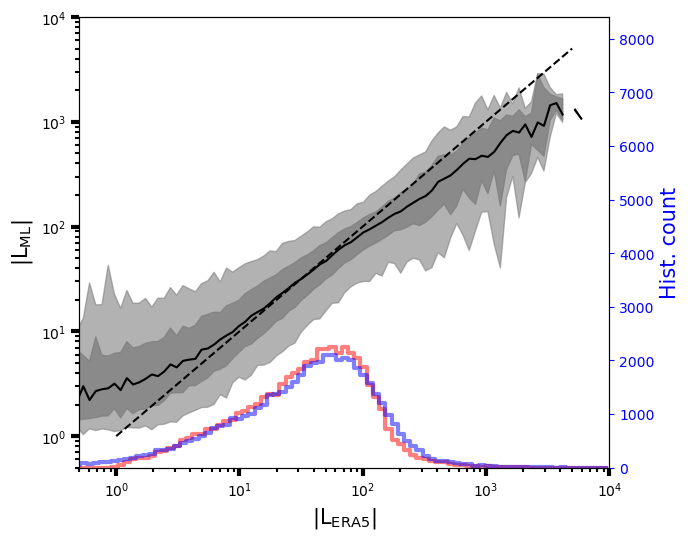

In [12]:
#%%
df_plot = pd.DataFrame()
df_plot['y_test'] = 10**result.y_test
df_plot['y_ML'] = 10**result.y_pred

hist_steps = 100
title = 'Correction using stacked regression from ERA5 $L$'
x_axis_title = r"|Obukhov length| validation (ERA5)"

L_param = 'L'
L_val = 'L_era5'
# L_val = 'L_buoy'

x_axis_title = r"|L$_{\mathrm{ERA5}}$|"
y_axis_title = r"|L$_{\mathrm{ML}}$|"
param_test = 'y_test'
param_predict = 'y_ML'
bin_centre, bin_median, bin_count_test, bin_count_pred, bin_std, fig2 = eqm.plot_envelope_single(df_plot = df_plot, hist_steps = hist_steps, param_test = param_test, param_predict = param_predict, 
                                                 title = title, x_axis_title = x_axis_title, y_axis_title = y_axis_title, alpha = 0.5, legend = False)

In [13]:
#%% load previous study
stacking_regressor = joblib.load(f"{data_dir}/examp_buoy_era5_regression_buoy_to_era5/" + "stacked_model.joblib")
y_pred = stacking_regressor.predict(result.X_test)

r2 = r2_score(result.y_test, y_pred)
mae = median_absolute_error(result.y_test, y_pred)
print(f"Buoy to ERA5: Model explains {np.round(r2*100,1)}% of variance with a Median Absolute Error of {np.round(mae,3)} (on a log scale)")

Buoy to ERA5: Model explains 77.6% of variance with a Median Absolute Error of 0.146 (on a log scale)
